# A writer identifier implementation that uses randomly generated training and test data from the IAM dataset

## Project Pipeline

This project adopts the following machine learning pipeline:

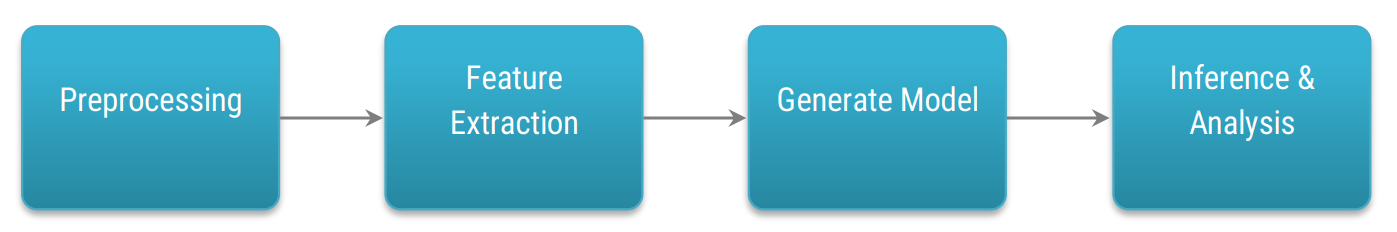

## Preprocessing

Input images are processed according to the chosen features extraction method, but whatever the chosen extraction method is, the image essentially goes through the same procedures. The preprocessing module simply crops the image to its useful content (i.e the handwritten text corpus) and returns a binarized version of the cropped image and a grayscale version depending on the type of the features extraction method.

## Features Extraction

The features extraction phase is inspired by [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0045790617322401). Two similar methods are implemented for extracting features from raw images. The first is implemented as proposed in the paper where the image is segmented into words images which are then overlapped into a single image to represent the texture of a particular writer’s handwriting. Texture images are then segmented into texture blocks that are each represented as an input vector for the next phase using their local binary pattern histograms.

The other feature extraction method works by simply feeding the model in the next phase raw segmented images (e.g sentences, words) of the cropped image. Despite being simple, this method takes much more time to execute than the overlapping method mentioned above as it takes an average execution time of 10 seconds per iteration while the overlapping method takes around 3.5 seconds per iteration, in addition to that, the overlapping method yields better accuracy by a slight yet accountable margin making matter disadvantageous for the lines method.

## Model Generation

The output of the previous step is feed to a model generator function that’s responsible for both generating and training a model. You can either choose a support vector machine classifier or a neural network classifier to classify test images. Both yield exceptional results when running on 1000 random samples, the neural network classifier has a slight edge over the SVM classifier in terms of accuracy as it achieves 98.8% accuracy compared to 98.2%. On the other side of the coin, the SVM classifier is faster than the neural network one having an average iteration runtime of 3.4 seconds instead of 14.7 seconds but keep in mind that neural network classifiers performance can be improved by GPU acceleration which indeed reduced the neural network classifier average iteration runtime from 14.7 seconds to 8.7 seconds.

## Training and Test Samples Generation

At each epoch, 3 random writers directories are chosen from the dataset where 2 random images are read from each writer's directory and an extra image to be used for testing is randomly chosen from the three writers' directories. This process ends up with 7 labelled images, 6 for training (2 for each writer) and 1 for testing.

In [1]:
import os
import random
import time
from os import walk
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.feature import local_binary_pattern
from skimage.measure import find_contours
from skimage.morphology import binary_dilation
from sklearn.svm import SVC
from torch import nn, optim
from torch.utils.data import TensorDataset
import torch.nn.functional as F

In [2]:
# Parameters and constants
AVAILABLE_WRITERS = 672
RESULTS_FILE = 'results.txt'
TIME_FILE = 'time.txt'
OVERLAPPING_METHOD = 0
LINES_METHOD = 1
SUPPORT_VECTOR_CLASSIFIER = 0
NEURAL_NETWORK_CLASSIFIER = 1
HISTOGRAM_BINS = 256
NN_LEARNING_RATE = 0.003
NN_WEIGHT_DECAY = 0.01
NN_DROPOUT = 0.25
NN_EPOCHS = 200
NN_BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [4]:
def preprocess_image(img, feature_extraction_method=OVERLAPPING_METHOD):
    if feature_extraction_method == OVERLAPPING_METHOD:
        img_copy = img.copy()
        if len(img.shape) > 2:
            img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
        img_copy = cv2.medianBlur(img_copy, 5)
        img_copy = cv2.threshold(img_copy, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        min_vertical, max_vertical = get_corpus_boundaries(img_copy)
        img_copy = img_copy[min_vertical:max_vertical]
        return img_copy

    if feature_extraction_method == LINES_METHOD:
        img_copy = img.copy()
        if len(img.shape) > 2:
            grayscale_img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
        else:
            grayscale_img = img.copy()
        img_copy = cv2.threshold(grayscale_img, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        min_vertical, max_vertical = get_corpus_boundaries(img_copy)
        img_copy = img_copy[min_vertical:max_vertical]
        grayscale_img = grayscale_img[min_vertical:max_vertical]
        filter_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        img_copy_sharpened = cv2.filter2D(img_copy, -1, filter_kernel)
        return img_copy_sharpened, grayscale_img

In [5]:
def get_corpus_boundaries(img):
    crop = []
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
    detect_horizontal = cv2.morphologyEx(img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    contours = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    prev = -1
    for i, c in enumerate(contours):
        if np.abs(prev - int(c[0][0][1])) > 800 or prev == -1:
            crop.append(int(c[0][0][1]))
            prev = int(c[0][0][1])
    crop.sort()
    max_vertical = crop[1] - 20
    min_vertical = crop[0] + 20
    return min_vertical, max_vertical

In [6]:
def segment_image(img, num, grayscale_img=None):
    if grayscale_img is not None:
        grayscale_images = []
        img_copy = np.copy(img)
        kernel = np.ones((1, num))
        img_copy = binary_dilation(img_copy, kernel)
        bounding_boxes = find_contours(img_copy, 0.8)
        for box in bounding_boxes:
            x_min = int(np.min(box[:, 1]))
            x_max = int(np.max(box[:, 1]))
            y_min = int(np.min(box[:, 0]))
            y_max = int(np.max(box[:, 0]))
            if (y_max - y_min) > 50 and (x_max - x_min) > 50:
                grayscale_images.append(grayscale_img[y_min:y_max, x_min:x_max])
        return grayscale_images
    images = []
    img_copy = np.copy(img)
    kernel = np.ones((1, num))
    img_copy = binary_dilation(img_copy, kernel)
    bounding_boxes = find_contours(img_copy, 0.8)
    for box in bounding_boxes:
        x_min = int(np.min(box[:, 1]))
        x_max = int(np.max(box[:, 1]))
        y_min = int(np.min(box[:, 0]))
        y_max = int(np.max(box[:, 0]))
        if (y_max - y_min) > 10 and (x_max - x_min) > 10:
            images.append(img[y_min:y_max, x_min:x_max])
    return images

In [7]:
def overlap_words(words, avg_height):
    overlapped_img = np.zeros((3600, 320))
    index_i = 0
    index_j = 0
    max_height = 0
    for word in words:
        if word.shape[1] + index_j > overlapped_img.shape[1]:
            max_height = 0
            index_j = 0
            index_i += int(avg_height // 2)
        if word.shape[1] < overlapped_img.shape[1] and word.shape[0] < overlapped_img.shape[0]:
            indices = np.copy(overlapped_img[index_i:index_i + word.shape[0], index_j:index_j + word.shape[1]])
            indices = np.maximum(indices, word)
            overlapped_img[index_i:index_i + word.shape[0], index_j:index_j + word.shape[1]] = indices
            index_j += word.shape[1]
            if max_height < word.shape[0]:
                max_height = word.shape[0]
    overlapped_img = overlapped_img[:index_i + int(avg_height // 2), :]
    return overlapped_img

In [8]:
def get_textures(image):
    index_i = 0
    index_j = 0
    texture_size = 100
    textures = []
    while index_i + texture_size < image.shape[0]:
        if index_j + texture_size > image.shape[1]:
            index_j = 0
            index_i += texture_size
        textures.append(np.copy(image[index_i: index_i + texture_size, index_j: index_j + texture_size]))
        index_j += texture_size
    return textures

In [9]:
def model_generator(features, labels, feature_extraction_method=OVERLAPPING_METHOD,
                    classifier_type=SUPPORT_VECTOR_CLASSIFIER):
    histograms = []

    if feature_extraction_method == OVERLAPPING_METHOD:
        for texture_array in features:
            for texture in texture_array:
                lbp = local_binary_pattern(texture, 8, 3, 'default')
                histogram, _ = np.histogram(lbp, density=False, bins=HISTOGRAM_BINS, range=(0, HISTOGRAM_BINS))
                histograms.append(histogram)

    elif feature_extraction_method == LINES_METHOD:
        for line in features:
            lbp = local_binary_pattern(line, 8, 3, 'default')
            histogram, _ = np.histogram(lbp, density=False, bins=HISTOGRAM_BINS, range=(0, HISTOGRAM_BINS))
            histograms.append(histogram)

    if classifier_type == SUPPORT_VECTOR_CLASSIFIER:
        model = SVC(kernel='linear')
        model.fit(histograms, labels)
        return model

    if classifier_type == NEURAL_NETWORK_CLASSIFIER:
        model = nn.Sequential(nn.Linear(HISTOGRAM_BINS, 128),
                              nn.ReLU(),
                              nn.Dropout(p=NN_DROPOUT),
                              nn.Linear(128, 64),
                              nn.ReLU(),
                              nn.Dropout(p=NN_DROPOUT),
                              nn.Linear(64, 3))
        model.to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adamax(model.parameters(), lr=NN_LEARNING_RATE, weight_decay=NN_WEIGHT_DECAY)
        inputs = torch.Tensor(histograms)
        labels = torch.tensor(labels, dtype=torch.long) - 1
        dataset = TensorDataset(inputs, labels)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=NN_BATCH_SIZE, shuffle=True)
        for epoch in range(NN_EPOCHS):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                output = model(inputs)
                loss = criterion(output, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return model

In [10]:
def predict(model, test_image, feature_extraction_method=OVERLAPPING_METHOD, classifier_type=SUPPORT_VECTOR_CLASSIFIER):
    if feature_extraction_method == OVERLAPPING_METHOD:
        img = preprocess_image(test_image)
        words = segment_image(img, 3)
        avg_height = 0
        for word in words:
            avg_height += word.shape[0] / len(words)
        overlapped_img = overlap_words(words, avg_height)
        textures = get_textures(overlapped_img)
        prediction = np.zeros(4)
        for texture in textures:
            lbp = local_binary_pattern(texture, 8, 3, 'default')
            histogram, _ = np.histogram(lbp, density=False, bins=HISTOGRAM_BINS, range=(0, HISTOGRAM_BINS))
            if classifier_type == SUPPORT_VECTOR_CLASSIFIER:
                prediction[model.predict([histogram])] += 1
            if classifier_type == NEURAL_NETWORK_CLASSIFIER:
                with torch.no_grad():
                    model.eval()
                    histogram = torch.Tensor(histogram)
                    probabilities = F.softmax(model.forward(histogram), dim=0)
                    _, top_class = probabilities.topk(1)
                    prediction[top_class + 1] += 1
        return np.argmax(prediction)

    if feature_extraction_method == LINES_METHOD:
        img, grayscale_img = preprocess_image(test_image, feature_extraction_method)
        grayscale_lines = segment_image(img, 100, grayscale_img)
        prediction = np.zeros(4)
        for line in grayscale_lines:
            lbp = local_binary_pattern(line, 8, 3, 'default')
            histogram, _ = np.histogram(lbp, density=False, bins=HISTOGRAM_BINS, range=(0, HISTOGRAM_BINS))
            if classifier_type == SUPPORT_VECTOR_CLASSIFIER:
                prediction[model.predict([histogram])] += 1
            if classifier_type == NEURAL_NETWORK_CLASSIFIER:
                with torch.no_grad():
                    model.eval()
                    histogram = torch.Tensor(histogram)
                    probabilities = F.softmax(model.forward(histogram), dim=0)
                    _, top_class = probabilities.topk(1)
                    prediction[top_class + 1] += 1
        return np.argmax(prediction)

In [11]:
def read_random_images(root):
    images = []
    labels = []
    test_images = []
    test_labels = []
    for i in range(3):
        found_images = False
        while not found_images:
            images_path = root
            random_writer = random.randrange(AVAILABLE_WRITERS)
            if random_writer < 10:
                random_writer = "00" + str(random_writer)
            elif random_writer < 100:
                random_writer = "0" + str(random_writer)
            images_path = os.path.join(images_path, str(random_writer))
            if not os.path.isdir(images_path):
                continue
            _, _, filenames = next(walk(images_path))
            if len(filenames) <= 2 and i == 2 and len(test_images) == 0:
                continue
            if len(filenames) >= 2:
                found_images = True
                chosen_filenames = []
                for j in range(2):
                    random_filename = random.choice(filenames)
                    while random_filename in chosen_filenames:
                        random_filename = random.choice(filenames)
                    chosen_filenames.append(random_filename)
                    images.append(cv2.imread(os.path.join(images_path, random_filename)))
                    labels.append(i + 1)
                if len(filenames) >= 3:
                    random_filename = random.choice(filenames)
                    while random_filename in chosen_filenames:
                        random_filename = random.choice(filenames)
                    chosen_filenames.append(random_filename)
                    test_images.append(cv2.imread(os.path.join(images_path, random_filename)))
                    test_labels.append(i + 1)
    test_choice = random.randint(0, len(test_images) - 1)
    test_image = test_images[test_choice]
    test_label = test_labels[test_choice]
    return images, labels, test_image, test_label

In [12]:
def extract_features(images, labels, feature_extraction_method=OVERLAPPING_METHOD):
    if feature_extraction_method == LINES_METHOD:
        lines_labels = []
        lines = []
        for image, label in zip(images, labels):
            image, grayscale_image = preprocess_image(image, feature_extraction_method)
            grayscale_lines = segment_image(image, 100, grayscale_image)
            for line in grayscale_lines:
                lines.append(line)
                lines_labels.append(label)
        return lines, lines_labels

    if feature_extraction_method == OVERLAPPING_METHOD:
        textures = []
        textures_labels = []
        for image, label in zip(images, labels):
            image = preprocess_image(image)
            words = segment_image(image, 3)
            avg_height = 0
            for word in words:
                avg_height += word.shape[0] / len(words)
            overlapped_img = overlap_words(words, avg_height)
            new_textures = get_textures(overlapped_img)
            textures.append(new_textures)
            for j in range(len(new_textures)):
                textures_labels.append(label)
        return textures, textures_labels

In [13]:
epochs = 100
root='../input/iam-handwritten-forms-dataset/data'
feature_extraction_method=OVERLAPPING_METHOD
classifier_type=SUPPORT_VECTOR_CLASSIFIER
correct_predictions = 0
total_execution_time = 0
for epoch in range(epochs):
    images, labels, test_image, test_label = read_random_images(root)
    start_time = time.time()
    features, features_labels = extract_features(images, labels, feature_extraction_method)
    model = model_generator(features, features_labels, feature_extraction_method, classifier_type)
    prediction = predict(model, test_image, feature_extraction_method, classifier_type)
    execution_time = time.time() - start_time
    total_execution_time += execution_time
    if prediction == test_label:
        correct_predictions += 1
    print("Epoch #{} | Execution time {} seconds | Model accuracy {}".format(epoch + 1, round(execution_time, 2), round((correct_predictions / (epoch + 1)) * 100, 2)))
print("Model accuracy = {}% using {} sample tests.".format((correct_predictions / epochs) * 100, epochs))
print("Total execution time = {} using {} sample tests.".format(round(total_execution_time, 2), epochs))

Epoch #1 | Execution time 4.99 seconds | Model accuracy 100.0
Epoch #2 | Execution time 4.15 seconds | Model accuracy 100.0
Epoch #3 | Execution time 4.53 seconds | Model accuracy 100.0
Epoch #4 | Execution time 3.92 seconds | Model accuracy 100.0
Epoch #5 | Execution time 4.41 seconds | Model accuracy 100.0
Epoch #6 | Execution time 4.93 seconds | Model accuracy 100.0
Epoch #7 | Execution time 4.53 seconds | Model accuracy 100.0
Epoch #8 | Execution time 3.68 seconds | Model accuracy 100.0
Epoch #9 | Execution time 3.44 seconds | Model accuracy 100.0
Epoch #10 | Execution time 5.2 seconds | Model accuracy 100.0
Epoch #11 | Execution time 3.56 seconds | Model accuracy 100.0
Epoch #12 | Execution time 4.58 seconds | Model accuracy 100.0
Epoch #13 | Execution time 3.77 seconds | Model accuracy 100.0
Epoch #14 | Execution time 4.2 seconds | Model accuracy 100.0
Epoch #15 | Execution time 3.24 seconds | Model accuracy 100.0
Epoch #16 | Execution time 3.93 seconds | Model accuracy 100.0
Epo